# 데이터 분석

In [663]:
import pandas as pd
import numpy as np
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.font_manager as fm

In [685]:
path = '../9.데이터/0.작업 데이터/0.전처리 데이터/'
path_3d = '../9.데이터/0.작업 데이터/9.3D 그래프/'

In [665]:
up_data_v1 = pd.read_csv(path + 'upline_data_v1.csv', encoding='utf-8')
down_data_v1 = pd.read_csv(path + 'downline_data_v1.csv', encoding='utf-8')

In [666]:
up_data_v1["datetime"] = up_data_v1["통계날짜"] + " " + up_data_v1["통계시각"]
up_data_v1["datetime"] = pd.to_datetime(up_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
up_data_v1["요일"] = up_data_v1["datetime"].dt.weekday

down_data_v1["datetime"] = down_data_v1["통계날짜"] + " " + down_data_v1["통계시각"]
down_data_v1["datetime"] = pd.to_datetime(down_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
down_data_v1["요일"] = down_data_v1["datetime"].dt.weekday

In [667]:
def to_pivot_data(dataset, values):
    dataset["차로"] = 1
    line1_data = dataset.copy()

    dataset["차로"] = 2
    line2_data = dataset.copy()

    dataset["차로"] = 3
    line3_data = dataset.copy()

    dataset["차로"] = 4
    line4_data = dataset.copy()

    line1_data = line1_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "1차로 교통량", "1차로 속도"]]
    line1_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line2_data = line2_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "2차로 교통량", "2차로 속도"]]
    line2_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line3_data = line3_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "3차로 교통량", "3차로 속도"]]
    line3_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line4_data = line4_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "4차로 교통량", "4차로 속도"]]
    line4_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]

    total_line= pd.concat([line1_data, line2_data, line3_data, line4_data])
    
    weekday_total = total_line.loc[total_line["요일"] <= 4]
    weekend_total = total_line.loc[total_line["요일"] > 4]
    
    pivot_weekday = pd.pivot_table(weekday_total, index=["통계시각"], columns= ["차로", "레이더ID"], values = values, aggfunc = 'mean')
    pivot_weekend = pd.pivot_table(weekend_total, index=["통계시각"], columns= ["차로", "레이더ID"], values = values, aggfunc = 'mean')
    
    return pivot_weekday, pivot_weekend

In [708]:
def create_3D_Graph(dataset, line, values, direction = True):
    pivot_weekday, pivot_weekend = to_pivot_data(dataset, values)
    pivot_list = [pivot_weekday, pivot_weekend]
    
    for i_list in pivot_list:
        
        if direction:
            x = range(288)
            y = range(int(i_list.shape[1]/4))
            Z = i_list[line].T.to_numpy()       

            X, Y = np.meshgrid(x, y)

            fig = plt.figure(1, figsize = (8, 8))
            ax = fig.add_subplot(111, projection = '3d')

            ax.set_title("시간-레이더 {} 그래프 ({}차로)".format(values, line), fontsize=12)

            ax.set_xlabel("Time")
            ax.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
            ax.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

            ax.set_ylabel("RADR")
            ax.set_yticks(list(range(int(i_list.shape[1]/4))))
            ax.set_yticklabels(list(range(1, int(i_list.shape[1]/4)+1)))

            ax.set_zlabel("{}".format(values))
            
            if values == "속도":
                ax.set_zlim(0, 110)
            else:
                ax.set_zlim(0, 170)

            surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)

            fig1, ax1 = plt.subplots()    
            
            ax1.set_xlabel("Time")
            ax1.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
            ax1.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

            ax1.set_ylabel("RADR")
            ax1.set_yticks(list(range(int(i_list.shape[1]/4))))
            ax1.set_yticklabels(list(range(1, int(i_list.shape[1]/4)+1)))
            
            contour = ax1.contourf(X, Y, Z, cmap=matplotlib.cm.coolwarm)
            plt.colorbar(contour)
            plt.show()
            
        else:
            x = range(int(i_list.shape[1]/4))
            y = range(288)
            Z = i_list[line].to_numpy()

            X, Y = np.meshgrid(x, y)

            fig = plt.figure(1, figsize = (8, 8))
            ax = fig.add_subplot(111, projection = '3d')

            ax.set_title("시간-레이더 {} 그래프 ({}차로)".format(values, line), fontsize=12)


            ax.set_xlabel("RADR")
            ax.set_xticks(list(range(int(i_list.shape[1]/4))))
            ax.set_xticklabels(list(range(1, int(i_list.shape[1]/4)+1)))

            ax.set_ylabel("Time")
            ax.set_yticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
            ax.set_yticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

            ax.set_zlabel("{}".format(values))
            
            if values == "속도":
                ax.set_zlim(0, 110)
            else:
                ax.set_zlim(0, 170)

            surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)

            fig1, ax1 = plt.subplots()    
            contour = ax1.contourf(X, Y, Z, cmap=matplotlib.cm.coolwarm)
            plt.colorbar(contour)
            plt.show()
            
        plt.show()

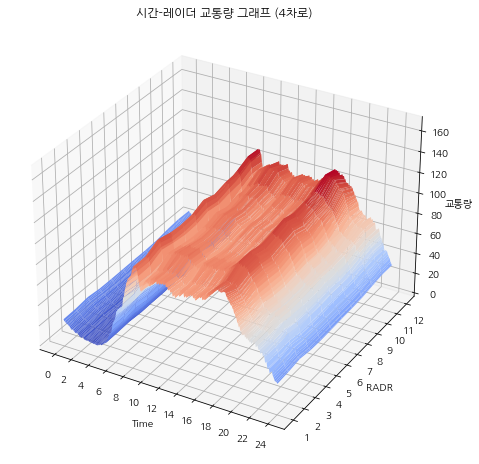

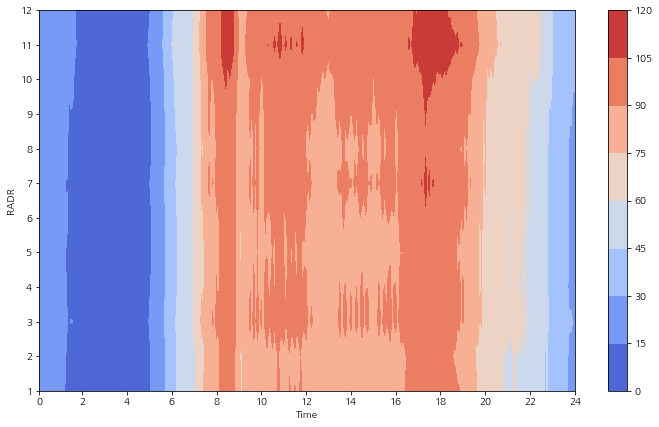

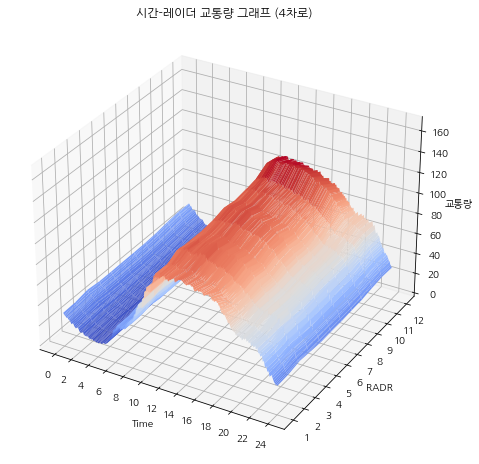

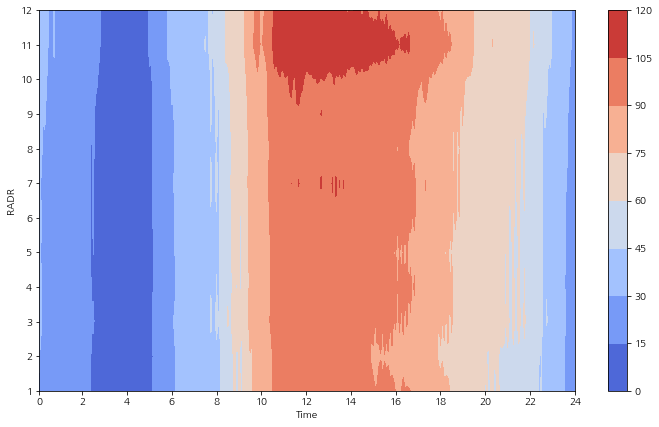

In [728]:
create_3D_Graph(down_data_v1, 4, "교통량", True)

In [372]:
up_speed_weekday, up_speed_weekend = to_pivot_data(up_data_v1, "속도")
up_volume_weekday, up_volume_weekend = to_pivot_data(up_data_v1, "교통량")
down_speed_weekday, down_speed_weekend = to_pivot_data(down_data_v1, "속도")
down_volume_weekday, down_volume_weekend = to_pivot_data(down_data_v1, "교통량")

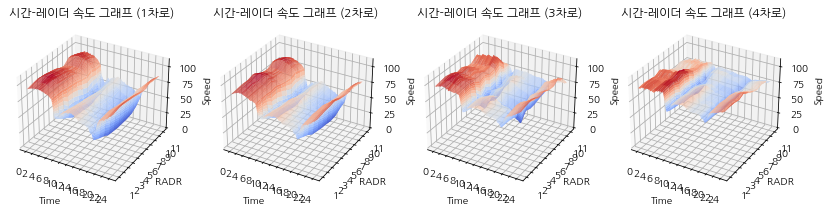

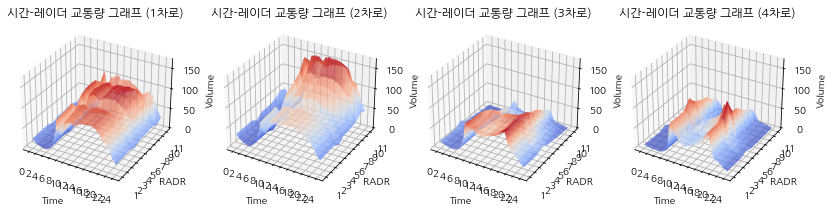

In [56]:
##  object oriented API 방식

x = range(288)
y = range(11)

X, Y = np.meshgrid(x, y)


fig1 = plt.figure(1, figsize = (14, 15))

for i in range(1,5):
    
    Z = up_speed[i].T.to_numpy()
    
    ax1 = fig1.add_subplot(1, 4, i, projection = '3d')
    
    ax1.set_title("시간-레이더 속도 그래프 ({}차로)".format(i), fontsize=12)
        
    ax1.set_xlabel("Time")
    ax1.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
    ax1.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

    ax1.set_ylabel("RADR")
    ax1.set_yticks(list(range(11)))
    ax1.set_yticklabels(list(range(1, 12)))

    ax1.set_zlabel("Speed")
    ax1.set_zlim(0, 110)

    surface = ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)

fig2 = plt.figure(2, figsize = (14, 15))


for i in range(1,5):
    
    Z = up_volume[i].T.to_numpy()
    
    ax2 = fig2.add_subplot(1, 4, i, projection = '3d')

    ax2.set_title("시간-레이더 교통량 그래프 ({}차로)".format(i), fontsize=12)
        
    ax2.set_xlabel("Time")
    ax2.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
    ax2.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

    ax2.set_ylabel("RADR")
    ax2.set_yticks(list(range(11)))
    ax2.set_yticklabels(list(range(1, 12)))

    ax2.set_zlabel("Volume")
    ax2.set_zlim(0, 170)

    surface = ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)    

plt.show()

In [62]:
up_speed[1]

레이더ID,RADR11,RADR12,RADR13,RADR14,RADR15,RADR16,RADR17,RADR18,RADR19,RADR20,RADR21
통계시각,,,,,,,,,,,
00:00:00,92.229135,94.347003,95.904306,94.925926,92.779180,91.200000,87.327948,85.437126,92.542424,89.485981,86.278351
00:05:00,93.242424,95.399689,97.046802,95.332353,93.021978,91.343849,87.343949,85.739458,92.984663,90.237654,87.123188
00:10:00,93.569018,95.473934,96.872611,96.279173,93.733017,92.129808,87.783172,86.152466,93.877301,90.783282,87.682482
00:15:00,93.349618,95.339089,97.383648,95.948680,93.886614,92.130915,88.065391,86.325337,93.783537,90.547170,87.291367
00:20:00,93.917557,95.737834,97.535545,96.388972,94.415482,92.544728,88.193548,86.384615,93.896226,90.855799,88.050725
...,...,...,...,...,...,...,...,...,...,...,...
23:35:00,90.500000,92.543210,94.043411,92.676343,90.454829,89.073668,85.780715,84.212976,90.468927,87.630986,84.888889
23:40:00,91.124233,93.156398,94.201562,93.091570,91.277865,89.653061,86.249605,84.480519,91.353276,88.512894,85.317610
23:45:00,91.544073,93.682889,95.132399,93.850291,91.981279,90.168770,86.478605,84.888244,91.594118,88.311765,86.131661


In [97]:
plt.rcParams['figure.figsize'] = [8, 5]

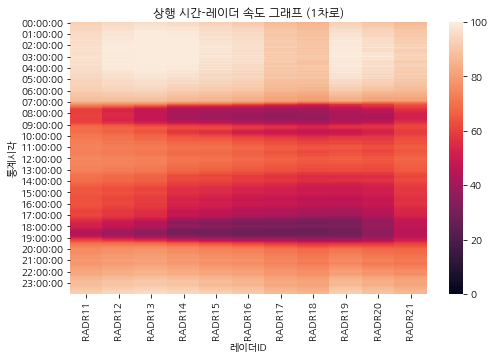

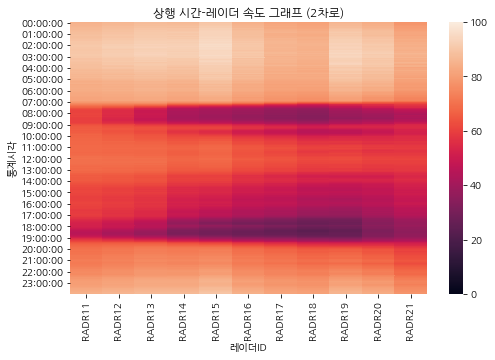

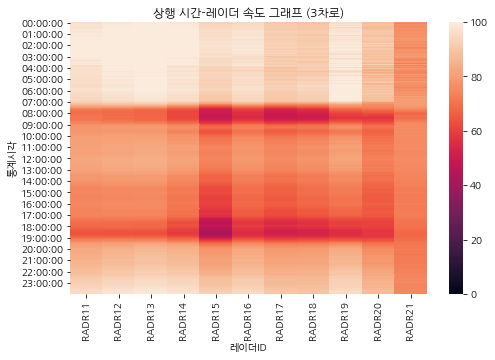

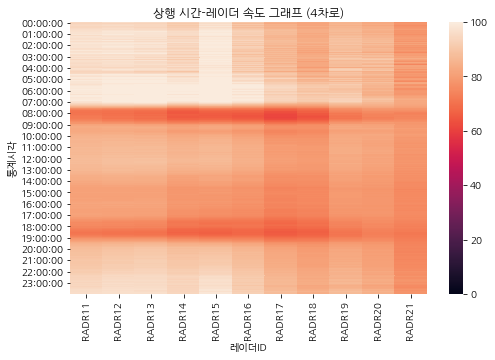

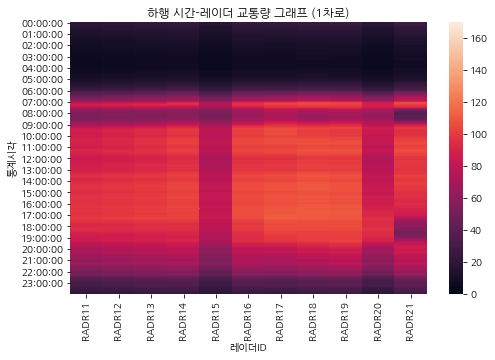

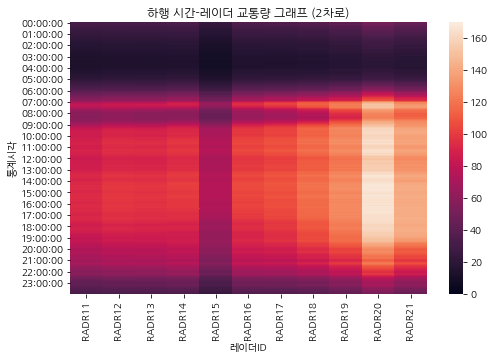

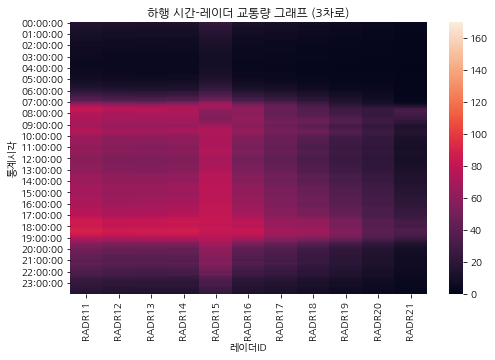

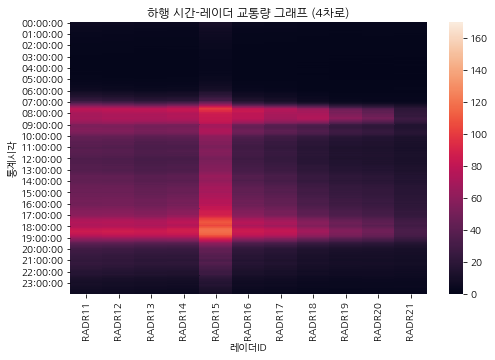

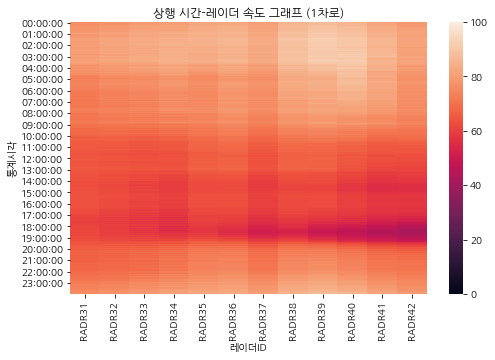

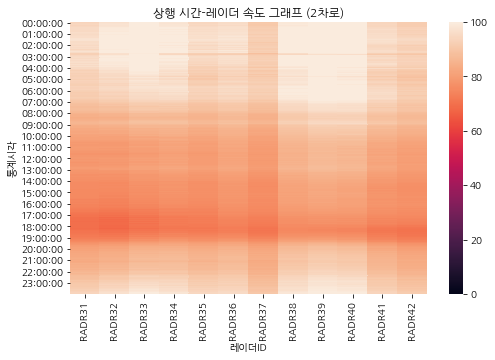

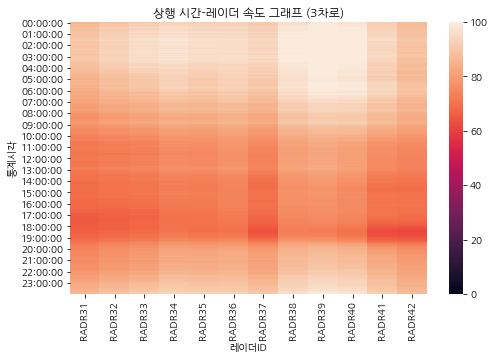

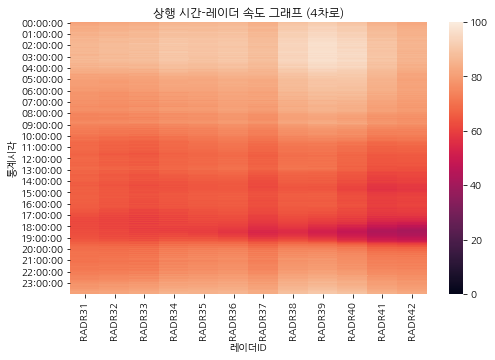

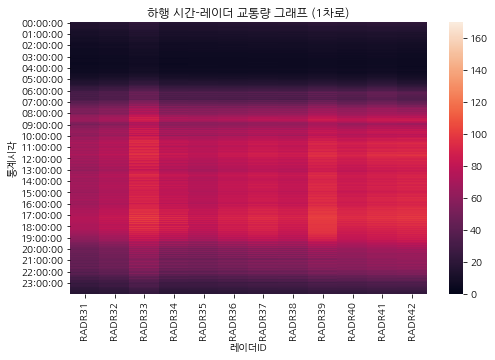

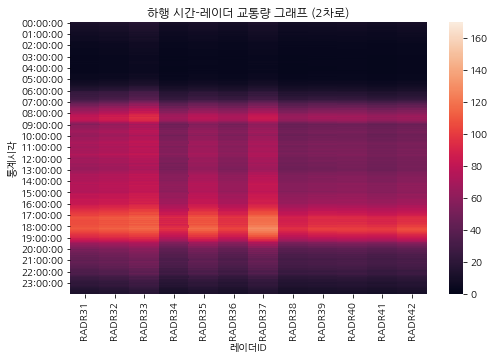

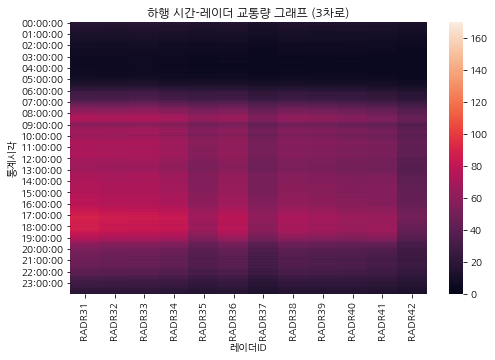

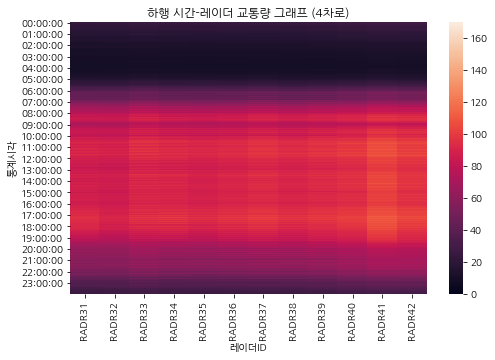

In [98]:
num = 1
data_list = [up_speed, up_volume, down_speed, down_volume]

for i in data_list:
    for it in range(1,5):
        if num % 2 == 1:
            ax = sns.heatmap(i[it], yticklabels = 12, vmin=0, vmax=100)
            if num == 1:
                plt.title("상행 시간-레이더 속도 그래프 ({}차로)".format(it), fontsize=15)
            else:
                plt.title("상행 시간-레이더 속도 그래프 ({}차로)".format(it), fontsize=15)
            plt.show()
        else:
            ax = sns.heatmap(i[it], yticklabels = 12, vmin=0, vmax=170)
            if num == 2:
                plt.title("하행 시간-레이더 교통량 그래프 ({}차로)".format(it), fontsize=15)
            else:
                plt.title("하행 시간-레이더 교통량 그래프 ({}차로)".format(it), fontsize=15)
            plt.show()
    num += 1

In [640]:
path_a = "../9.데이터/0.작업 데이터/1.차선별 데이터/"
path_h = "../9.데이터/0.작업 데이터/2.사고 데이터/0.히트맵/"

In [108]:
up_speed.to_csv(path_a + 'upline_speed.csv', encoding='utf-8')
up_volume.to_csv(path_a + 'upline_volume.csv', encoding='utf-8')
down_speed.to_csv(path_a + 'downline_speed.csv', encoding='utf-8')
down_volume.to_csv(path_a + 'downline_volume.csv', encoding='utf-8')

In [591]:
def to_pivot_data_TEST(dataset, values):
    dataset["차로"] = 1
    line1_data = dataset.copy()

    dataset["차로"] = 2
    line2_data = dataset.copy()

    dataset["차로"] = 3
    line3_data = dataset.copy()

    dataset["차로"] = 4
    line4_data = dataset.copy()

    line1_data = line1_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "1차로 교통량", "1차로 속도"]]
    line1_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line2_data = line2_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "2차로 교통량", "2차로 속도"]]
    line2_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line3_data = line3_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "3차로 교통량", "3차로 속도"]]
    line3_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line4_data = line4_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "4차로 교통량", "4차로 속도"]]
    line4_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]

    total_line= pd.concat([line1_data, line2_data, line3_data, line4_data])
    
    weekday_total = total_line.loc[total_line["요일"] <= 4]
    weekend_total = total_line.loc[total_line["요일"] > 4]
    
    weekday_date = weekday_total["통계날짜"].unique()
    weekend_date = weekend_total["통계날짜"].unique()
    
    pivot_weekday = pd.pivot_table(weekday_total, index=["통계날짜", "통계시각"], columns= ["차로", "레이더ID"], values = values)
    pivot_weekend = pd.pivot_table(weekend_total, index=["통계날짜", "통계시각"], columns= ["차로", "레이더ID"], values = values)
    
    return pivot_weekday, pivot_weekend, weekday_date, weekend_date

In [581]:
up_speed_weekday, up_speed_weekend = to_pivot_data(up_data_v1, "속도")
up_volume_weekday, up_volume_weekend = to_pivot_data(up_data_v1, "교통량")
down_speed_weekday, down_speed_weekend = to_pivot_data(down_data_v1, "속도")
down_volume_weekday, down_volume_weekend = to_pivot_data(down_data_v1, "교통량")

In [582]:
up_speed_weekday_TEST, up_speed_weekend_TEST = to_pivot_data_TEST(up_data_v1, "속도")
up_volume_weekday_TEST, up_volume_weekend_TEST = to_pivot_data_TEST(up_data_v1, "교통량")
down_speed_weekday_TEST, down_speed_weekend_TEST = to_pivot_data_TEST(down_data_v1, "속도")
down_volume_weekday_TEST, down_volume_weekend_TEST = to_pivot_data_TEST(down_data_v1, "교통량")

In [580]:
date_list = up_data_v1["통계날짜"].unique()

In [734]:
RADR_list = down_data_v1["레이더ID"].unique()

In [657]:
def create_accident_list(dataset, values, RADR_list):
    
    plt.rcParams['figure.figsize'] = [12, 7]
    
    pivot_weekday, pivot_weekend = to_pivot_data(dataset, values)
    pivot_weekday_TEST, pivot_weekend_TEST, weekday_date, weekend_date = to_pivot_data_TEST(dataset, values)

    pivot_list = [pivot_weekday, pivot_weekend]
    num = 0
    
    for p_it in pivot_list:
        if num == 0:
            c_it = pivot_weekday_TEST
            date_list = weekday_date
        else:
            c_it = pivot_weekend_TEST
            date_list = weekend_date
        
        num += 1
        
        accident_list = []
        accident_list_name = []
        accident_num = 0
        
        for itm in date_list:

            each_date = c_it.loc[itm]
            test = (p_it - each_date) - (p_it * 0.3)
            test = test.reset_index()

            for i in range(1, 5):

                for j in RADR_list:

                    if len(test.loc[test[i, j]>0][i, j]) > 6:

                        index_list = test.loc[test[i, j]>0][i, j].index

                        if i == 1:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), :11]
                        elif i == 2:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), 11:22]
                        elif i == 3:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), 22:33]
                        else:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), 33:]

                        ax = sns.heatmap(accident, yticklabels = 11, vmin=0, vmax=100, cbar=False)
                        plt.title("{} {}차선 {} - accident#{}".format(itm, i, j,accident_num), fontsize=15)
                        fig = ax.get_figure()
                        fig.savefig(path_h + "{} {}차선 {} - accident#{}".format(itm, i, j,accident_num) + ".jpg", dpi=400)
                        
                        ax = 0
                        fig = 0
                        
                        accident_list.append(accident)
                        accident_list_name.append(itm)

                        accident_num += 1

                    break

            
    return accident_list, accident_list_name

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

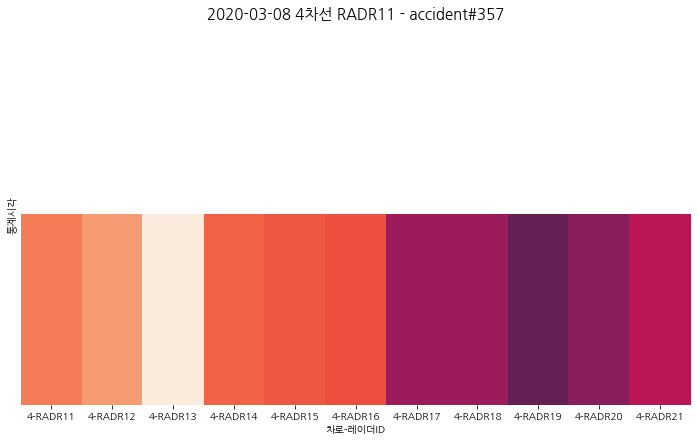

In [658]:
accident_list, accident_list_name = create_accident_list(up_data_v1, "속도", RADR_list)

C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\tools\Anaconda3\envs\test\lib\site-packages\seaborn\matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.da

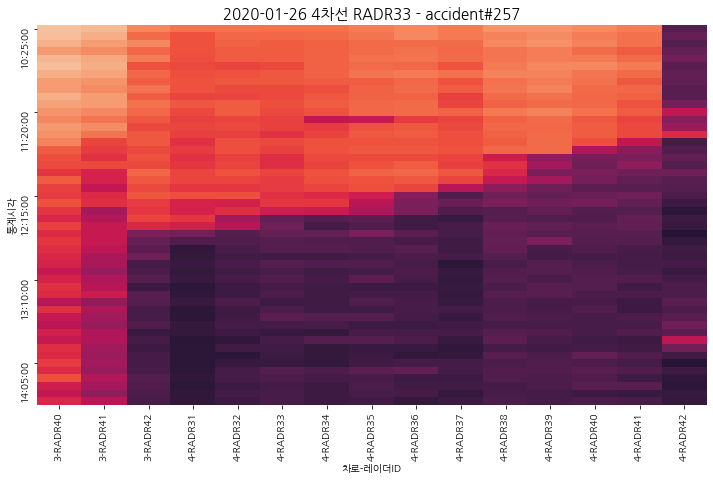

In [735]:
down_accident_list, down_accident_list_name = create_accident_list(down_data_v1, "속도", RADR_list)

In [731]:
accident_unique = set(accident_list_name)

In [733]:
len(accident_unique)

121

In [736]:
down_accident_unique = set(down_accident_list_name)
len(down_accident_unique)

73

In [610]:
for i in range(3449):
    print(accident_list_name[i])

2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-03
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-10
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-17
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24
2018-02-24

2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-23
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-29
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2018-12-30
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-05
2019-01-12
2019-01-12
2019-01-12
2019-01-12
2019-01-12
2019-01-12
2019-01-12
2019-01-12
2019-01-12
2019-01-12

2019-09-29
2019-09-29
2019-09-29
2019-09-29
2019-09-29
2019-09-29
2019-09-29
2019-09-29
2019-09-29
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-05
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-06
2019-10-12
2019-10-12
2019-10-12
2019-10-12
2019-10-13
2019-10-13
2019-10-13
2019-10-13
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-19
2019-10-20
2019-10-20
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-26
2019-10-27
2019-10-27
2019-10-27
2019-10-27
2019-10-27

In [571]:
up_speed_weekday_TEST.iloc[350:400]#.loc['2018-02-02']

차로                       1                                                   \
레이더ID               RADR11 RADR12 RADR13 RADR14 RADR15 RADR16 RADR17 RADR18   
통계날짜       통계시각                                                               
2018-02-01 23:05:00   88.0   91.0   94.0    NaN   90.0   90.0   89.0   90.0   
           23:10:00   89.0   93.0   91.0    NaN   92.0   88.0   88.0   87.0   
           23:15:00   90.0   94.0   94.0    NaN   96.0   94.0   89.0   88.0   
           23:20:00   95.0   97.0   95.0    NaN   96.0   94.0   93.0   95.0   
           23:25:00  100.0  102.0  108.0    NaN  103.0  100.0   96.0   95.0   
           23:30:00   99.0  102.0  103.0    NaN  100.0   98.0   96.0   94.0   
           23:35:00   94.0   97.0   99.0    NaN  101.0   96.0   94.0   92.0   
           23:40:00   97.0   98.0  100.0    NaN   99.0  100.0  100.0  100.0   
           23:45:00   94.0   99.0  102.0    NaN   99.0   99.0   93.0   90.0   
           23:50:00   91.0   93.0   96.0    NaN   93.0   95.0   95.0   96.0   
           23:55:00   97.0   98.0   99.0    NaN   96.0   95.0   94.0   90.0   
2018-02-05 00:00:00    NaN   90.0    NaN    NaN   88.0   85.0   86.0   86.0   
           00:05:00   89.0   90.0    NaN    NaN    NaN    NaN   87.0   86.0   
           00:10:00   90.0   90.0    NaN    NaN   90.0   90.0   90.0   90.0   
           00:15:00   88.0   89.0    NaN    NaN   90.0   88.0   85.0    NaN   
           00:20:00   98.0  102.0    NaN    NaN   96.0   99.0    NaN    NaN   
           00:25:00   98.0  103.0    NaN    NaN  103.0  100.0    NaN    NaN   
           00:30:00   84.0   93.0    NaN    NaN    NaN    NaN    NaN    NaN   
           00:35:00    NaN    NaN    NaN    NaN  109.0  103.0    NaN    NaN   
           00:40:00   95.0  103.0    NaN    NaN  105.0  108.0    NaN    NaN   
           00:45:00   96.0   97.0    NaN    NaN    NaN    NaN    NaN    NaN   
           00:50:00   91.0   93.0    NaN    NaN    NaN    NaN    NaN    NaN   
           00:55:00   79.0   83.0    NaN    NaN   86.0   82.0   82.0   81.0   
           01:00:00   99.0  100.0    NaN    NaN   98.0   98.0   93.0   92.0   
           01:05:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           01:10:00   93.0   94.0    NaN    NaN   92.0  106.0   95.0   95.0   
           01:25:00   91.0   95.0    NaN    NaN   90.0   93.0   90.0   89.0   
           01:30:00    NaN   96.0    NaN    NaN   90.0   81.0   74.0   77.0   
           01:35:00   92.0   98.0    NaN    NaN  100.0  101.0   93.0    NaN   
           01:40:00   95.0   97.0    NaN    NaN   97.0    NaN    NaN    NaN   
           01:45:00  103.0  106.0    NaN    NaN  105.0  105.0  102.0    NaN   
           01:50:00   89.0    NaN    NaN    NaN    NaN   87.0    NaN    NaN   
           02:05:00    NaN   80.0    NaN    NaN   85.0   84.0   94.0   92.0   
           02:10:00   74.0   78.0    NaN    NaN   74.0   80.0   79.0   81.0   
           02:40:00   91.0    NaN    NaN    NaN  101.0  100.0   95.0    NaN   
           02:45:00    NaN    NaN    NaN    NaN   91.0   95.0   86.0   96.0   
           02:50:00   90.0   92.0    NaN    NaN   95.0   94.0   94.0   98.0   
           02:55:00   98.0  102.0    NaN    NaN    NaN   99.0    NaN    NaN   
           03:00:00   78.0   79.0    NaN    NaN   84.0   85.0   87.0  117.0   
           03:10:00   86.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           03:15:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           03:20:00   98.0    NaN    NaN    NaN   93.0    NaN    NaN    NaN   
           03:30:00   84.0   86.0    NaN    NaN   83.0   92.0    NaN    NaN   
           03:40:00  115.0  117.0    NaN    NaN    NaN    NaN    NaN    NaN   
           03:45:00  105.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           04:05:00   95.0   96.0    NaN    NaN    NaN    NaN    NaN    NaN   
           04:10:00   96.0  101.0    NaN    NaN  101.0   98.0   98.0   98.0   
           04:15:00   92.0   94.0    NaN    NaN   

In [551]:
check_test

차로            1                                                          \
레이더ID    RADR11 RADR12 RADR13 RADR14 RADR15 RADR16 RADR17 RADR18 RADR19   
통계시각                                                                      
00:00:00  102.0  102.0  108.0    NaN  104.0  103.0   96.0   93.0   93.0   
00:05:00  100.0  102.0  103.0    NaN   99.0  101.0   97.0    NaN    NaN   
00:10:00   90.0   90.0   96.0    NaN   96.0   96.0   97.0   95.0  100.0   
00:15:00   95.0   99.0  100.0    NaN  100.0  101.0   97.0   94.0   96.0   
00:20:00   91.0  101.0  102.0    NaN  100.0   97.0   92.0   91.0    NaN   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
23:35:00   94.0   97.0   99.0    NaN  101.0   96.0   94.0   92.0   92.0   
23:40:00   97.0   98.0  100.0    NaN   99.0  100.0  100.0  100.0  101.0   
23:45:00   94.0   99.0  102.0    NaN   99.0   99.0   93.0   90.0   93.0   
23:50:00   91.0   93.0   96.0    NaN   93.0   95.0   95.0   96.0   96.0   
23:55:00   97.0   98.0   99.0    NaN   96.0   95.0   94.0   90.0   89.0   

차로               ...      4                                                   \
레이더ID    RADR20  ... RADR12 RADR13 RADR14 RADR15 RADR16 RADR17 RADR18 RADR19   
통계시각             ...                                                           
00:00:00   93.0  ...  122.0  123.0    NaN  124.0  119.0  108.0  103.0  106.0   
00:05:00    NaN  ...   76.0   86.0    NaN  102.0   81.0   61.0    NaN    NaN   
00:10:00   94.0  ...   95.0  101.0    NaN  106.0   86.0   89.0   81.0   87.0   
00:15:00   93.0  ...   92.0   93.0    NaN  113.0   95.0  111.0   75.0   78.0   
00:20:00    NaN  ...  121.0  125.0    NaN  117.0  115.0  129.0  161.0    NaN   
...         ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
23:35:00   90.0  ...  122.0  103.0    NaN  127.0  127.0  127.0  133.0  102.0   
23:40:00   95.0  ...   93.0   87.0    NaN   98.0   85.0   81.0   80.0   81.0   
23:45:00   89.0  ...   82.0  103.0    NaN  101.0  122.0  106.0  106.0   78.0   
23:50:00   93.0  ...  102.0  108.0    NaN  103.0  116.0  105.0  103.0   87.0   
23:55:00   92.0  ...  104.0  111.0    NaN  111.0   86.0   83.0   84.0   91.0   

차로                      
레이더ID    RADR20 RADR21  
통계시각                    
00:00:00   83.0   81.0  
00:05:00    NaN    NaN  
00:10:00   90.0   77.0  
00:15:00   74.0   70.0  
00:20:00    NaN    NaN  
...         ...    ...  
23:35:00   92.0   71.0  
23:40:00   80.0   72.0  
23:45:00   78.0   77.0  
23:50:00   86.0   81.0  
23:55:00   91.0   90.0  

[262 rows x 44 columns]

In [525]:
index_list[0]

88

In [526]:
check_test.iloc[(index_list[0] - 5):(index_list[0] +43), :11]

차로            1                                                          \
레이더ID    RADR11 RADR12 RADR13 RADR14 RADR15 RADR16 RADR17 RADR18 RADR19   
통계시각                                                                      
07:10:00   73.0   71.0   67.0   60.0   52.0   43.0   29.0   26.0    NaN   
07:15:00   64.0   50.0   31.0   24.0   23.0   22.0   25.0   28.0    NaN   
07:20:00   32.0   23.0   18.0   19.0   19.0   20.0   21.0   25.0    NaN   
07:25:00   19.0   15.0   15.0   14.0   16.0   18.0   22.0   25.0    NaN   
07:30:00   13.0   13.0   14.0   13.0   15.0   17.0   17.0   23.0    NaN   
07:35:00   14.0   14.0   13.0   16.0   14.0   18.0   17.0   20.0    NaN   
07:40:00   10.0    8.0   10.0   11.0   12.0   12.0   15.0   20.0    NaN   
07:45:00    8.0    9.0   10.0   10.0   10.0   10.0   13.0   15.0    NaN   
07:50:00    7.0    8.0    8.0    8.0    9.0   10.0   12.0   15.0    NaN   
07:55:00    7.0    6.0    6.0    7.0    9.0   10.0   12.0   15.0    NaN   
08:00:00    6.0    8.0    8.0    8.0    9.0   10.0   13.0   16.0    NaN   
08:05:00    8.0    6.0    6.0    7.0    7.0    9.0   10.0   17.0    NaN   
08:10:00    6.0    6.0    6.0    8.0    7.0    8.0   10.0   13.0    NaN   
08:15:00   12.0    6.0    6.0    5.0    6.0    8.0    8.0   14.0    NaN   
08:20:00    8.0    5.0    6.0    8.0    9.0    8.0    9.0   11.0    NaN   
08:25:00   35.0    7.0    7.0    7.0    9.0   10.0   10.0   14.0    NaN   
08:30:00   73.0   11.0    7.0    7.0    7.0    9.0   11.0   13.0    NaN   
08:35:00   67.0    8.0    8.0    8.0    8.0    9.0   10.0   13.0    NaN   
08:40:00   53.0   10.0   11.0   10.0   10.0    9.0   12.0   15.0    NaN   
08:45:00   50.0   15.0   13.0   12.0   14.0   13.0   17.0   20.0    NaN   
08:50:00   42.0   11.0   11.0   12.0   11.0   13.0   15.0   21.0    NaN   
08:55:00   31.0   20.0   17.0   17.0   20.0   21.0   21.0   22.0    NaN   
09:00:00   76.0   44.0   27.0   22.0   19.0   23.0   24.0   24.0    NaN   
09:05:00   79.0   75.0   49.0   20.0   18.0   18.0   23.0   27.0    NaN   
09:10:00   74.0   71.0   66.0   42.0   25.0   27.0   24.0   26.0    NaN   
09:15:00   79.0   79.0   73.0   57.0   26.0   21.0   23.0   27.0    NaN   
09:20:00   79.0   75.0   71.0   55.0   34.0   27.0   26.0   32.0    NaN   
09:25:00   75.0   72.0   71.0   65.0   40.0   29.0   26.0   34.0    NaN   
09:30:00   77.0   74.0   71.0   63.0   33.0   25.0   26.0   34.0    NaN   
09:35:00   72.0   73.0   71.0   68.0   42.0   29.0   29.0   32.0    NaN   
09:40:00   75.0   72.0   72.0   71.0   69.0   40.0   28.0   30.0    NaN   
09:45:00   75.0   73.0   68.0   70.0   69.0   51.0   29.0   29.0    NaN   
09:50:00   81.0   80.0   75.0   74.0   72.0   46.0   33.0   37.0    NaN   
09:55:00   73.0   74.0   72.0   70.0   71.0   61.0   37.0   34.0    NaN   
10:00:00   84.0   82.0   79.0   78.0   77.0   76.0   70.0   57.0    NaN   
10:05:00   78.0   76.0   72.0   71.0   73.0   72.0   73.0   70.0    NaN   
10:10:00   72.0   72.0   73.0   73.0   75.0   72.0   71.0   71.0    NaN   
10:15:00   80.0   79.0   79.0   74.0   75.0   71.0   68.0   67.0    NaN   
10:20:00   75.0   74.0   75.0   73.0   71.0   70.0   69.0   65.0    NaN   
10:25:00   76.0   74.0   72.0   71.0   71.0   70.0   70.0   69.0    NaN   
10:30:00   81.0   78.0   77.0   75.0   74.0   72.0   73.0   68.0    NaN   
10:35:00   81.0   80.0   79.0   78.0   76.0   73.0   73.0   69.0    NaN   
10:40:00   76.0   75.0   76.0   75.0   76.0   76.0   73.0   72.0    NaN   
10:45:00   79.0   78.0   75.0   73.0   75.0   73.0   70.0   67.0    NaN   
10:50:00   79.0   79.0   77.0   76.0   74.0   75.0   74.0   71.0    NaN   
10:55:00   79.0   79.0   77.0   74.0   74.0   74.0   71.0   70.0    NaN   
11:00:00   77.0   76.0   74.0   73.0   73.0   75.0   74.0   71.0    NaN   
11:05:00   81.0   80.0   79.0   78.0   78.0   77.0   76.0   74.0    NaN   

차로                      
레이더ID    RADR20 RADR21  
통계시각                    
07:10:00    NaN    NaN  
07:15:00    NaN    NaN  
07:20:00    NaN    NaN  
07:25:00    NaN    NaN  

In [504]:
index_list[0] - 5

83

In [ ]:
def create_minus_data_list(dataset, values, date_list, RADR_list):
    pivot_weekday, pivot_weekend = to_pivot_data_TEST(dataset, values)

    list_minus15 = []
    
    for itm in date_list:
        minus_data = pivot_weekday.loc[itm] - up_speed_weekday
        minus_data_test = minus_data.reset_index()
        
        col_num = 1
        
        for i in range(1, 5):
            for j in RADR_list:
                col_num += 1
                if len(minus_data_test.loc[minus_data_test[i, j] < -40][i,j]) != 0:
                    index_list = minus_data_test.loc[minus_data_test[i, j] < -40][i,j].index
                    for it in index_list:
                        data = minus_data_test.iloc[it-4:it+5, col_num - 1:col_num + 4]
                        list_minus15.append(data)
    return list_minus15



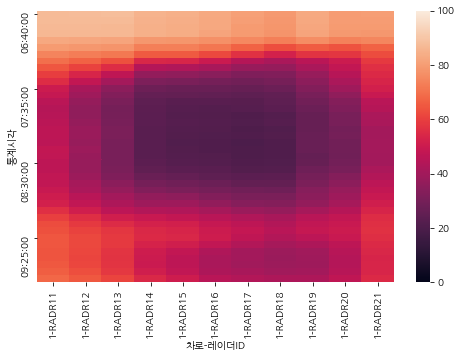

In [447]:
ax = sns.heatmap(up_speed_weekday.iloc[80:120, :11], yticklabels = 11, vmin=0, vmax=100)

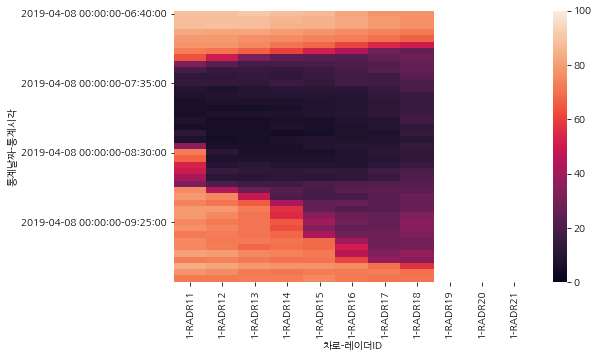

In [448]:
ax = sns.heatmap(up_speed_weekday_TEST.loc["2019-04-08"].iloc[77:120, :11], yticklabels = 11, vmin=0, vmax=100)

In [388]:
def create_minus_data_list(dataset, values, date_list, RADR_list):
    pivot_weekday, pivot_weekend = to_pivot_data_TEST(dataset, values)

    list_minus15 = []
    
    for itm in date_list:
        minus_data = pivot_weekday.loc[itm] - up_speed_weekday
        minus_data_test = minus_data.reset_index()
        
        col_num = 1
        
        for i in range(1, 5):
            for j in RADR_list:
                col_num += 1
                if len(minus_data_test.loc[minus_data_test[i, j] < -40][i,j]) != 0:
                    index_list = minus_data_test.loc[minus_data_test[i, j] < -40][i,j].index
                    for it in index_list:
                        data = minus_data_test.iloc[it-4:it+5, col_num - 1:col_num + 4]
                        list_minus15.append(data)
    return list_minus15



In [389]:
check = create_minus_data_list(up_data_v1, "속도", date_list, RADR_list)

KeyError: numpy.datetime64('2018-02-02T00:00:00.000000000')

In [330]:
len(check)

116096

In [332]:
check[60000]

차로             3                                            
레이더ID     RADR13     RADR14     RADR15     RADR16     RADR17
104          NaN        NaN        NaN        NaN        NaN
105   -33.554012 -34.071637 -48.448331 -38.273717 -39.005874
106   -46.338485 -46.518950 -46.982567 -40.706065 -33.831361
107   -39.637209 -36.852601 -50.924290 -35.453560 -34.961424
108   -39.037094 -37.856313 -52.363924 -36.749226 -31.641791
109   -39.667692 -44.602899 -52.414944 -34.109034 -28.308260
110   -28.989231 -37.223988 -52.926868 -29.217391 -31.001493
111   -18.152074 -23.276259 -56.743265 -32.245723 -31.749621
112   -28.634109 -27.726087 -53.254372 -32.636505 -29.959091

In [183]:
minus_data = test_up_speed.loc["2018-01-31"] - up_speed

In [225]:
test_minus_data = minus_data.loc[minus_data[3, "RADR21"] < -15][3,"RADR21"].copy()

In [238]:
minus_data.loc[minus_data[3, "RADR21"] < -15][3,"RADR21"].index

Index(['18:25:00', '22:40:00'], dtype='object', name='통계시각')

In [259]:
index_list = minus_data_test.loc[minus_data_test[1, "RADR11"] < 15][1, "RADR11"].index

In [260]:
index_list

Int64Index([184, 185, 186, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198,
            200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 218, 229, 230,
            233, 234, 235, 236, 237, 238, 244, 245, 246, 247, 248, 249, 250,
            251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
            264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
            277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287],
           dtype='int64')

221
32
차로             3                                4           
레이더ID     RADR19     RADR20     RADR21     RADR11     RADR12
217    13.313158   2.755263  -8.118421   9.004491  13.449387
218    13.916010   6.062992  -3.094737   7.310912  10.280675
219    10.018373   5.299213  -2.572178   6.497006   5.931193
220    10.445910  -3.833773  -9.298153   9.098655  10.819847
221     8.981627   1.010499 -21.852243   9.885075  10.512977
222     9.328042   1.986772  -8.466667  13.374813  10.113497
223    10.039683  -0.976190 -10.111406  12.005979  13.653905
224    15.824147  10.055118  -7.039578  15.849478  14.458015
225    20.018470   4.717678   1.007958  14.372578  14.025954
272
32
차로             3                                4           
레이더ID     RADR19     RADR20     RADR21     RADR11     RADR12
268    -5.452128  -8.226064  -0.010811  -4.696375  -1.979876
269     1.352785   3.117333  -8.804348   8.406344   3.063566
270    13.946809   7.898396   3.479564   9.244745  12.105100
271     7.

In [311]:
list_minus15[0]

차로             3                                4           
레이더ID     RADR19     RADR20     RADR21     RADR11     RADR12
217    13.313158   2.755263  -8.118421   9.004491  13.449387
218    13.916010   6.062992  -3.094737   7.310912  10.280675
219    10.018373   5.299213  -2.572178   6.497006   5.931193
220    10.445910  -3.833773  -9.298153   9.098655  10.819847
221     8.981627   1.010499 -21.852243   9.885075  10.512977
222     9.328042   1.986772  -8.466667  13.374813  10.113497
223    10.039683  -0.976190 -10.111406  12.005979  13.653905
224    15.824147  10.055118  -7.039578  15.849478  14.458015
225    20.018470   4.717678   1.007958  14.372578  14.025954

In [207]:
minus_data.loc[minus_data[1, "RADR12"] < 0][1, "RADR11"]

통계시각
23:05:00    0.231928
23:10:00   -0.679818
23:55:00   -4.357686
Name: (1, RADR11), dtype: float64

In [179]:
up_data_v1["통계날짜"].unique()

array(['2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03',
       '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07',
       '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11',
       '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
       '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19',
       '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23',
       '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27',
       '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03',
       '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07',
       '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11',
       '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15',
       '2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19',
       '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
       '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27',
       '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31',
       '2018-04-01', '2018-04-02', '2018-04-03', '2018-

In [572]:
a = 4

In [577]:
a < 4

False